In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
import os
# import cudf

## 1. Load the Data

In [2]:
INPUT_PATH = "/kaggle/input/h-and-m-personalized-fashion-recommendations"
articles_df = pd.read_csv(f"{INPUT_PATH}/articles.csv")
customers_df = pd.read_csv(f"{INPUT_PATH}/customers.csv")
submission = pd.read_csv(f"{INPUT_PATH}/sample_submission.csv")

**Reduce memory of train transactions data**

In [3]:
def read_csv_reduce_memory(csv_path, read_ratio=0.1):
    nrows = 31788324
    train = pd.read_csv(csv_path, nrows=int(nrows*read_ratio))
    train['article_id'] = train['article_id'].astype('int32')
    train['t_dat'] = pd.to_datetime(train['t_dat'])
    # train['year'] = (train.t_dat.dt.year-2000).astype('int8')
    # train['month'] = (train.t_dat.dt.month).astype('int8')
    # train['day'] = (train.t_dat.dt.day).astype('int8')
    train['price'] = train['price'].astype('float32')
    train['sales_channel_id'] = train['sales_channel_id'].astype('int8')

    return train

train_data = read_csv_reduce_memory(f"{INPUT_PATH}/transactions_train.csv")
train_data = pd.read_csv(f"{INPUT_PATH}/transactions_train.csv")

## 2a. Articles Dataset

`article_id`: Unique identifier of an article  
`product_code`, `prod_name`: Identifies the product and its name  
`product_type_no`, `product_type_name`: id of the product_code's group and its name  
`graphical_appearance_no`, `graphical_appearance_name`: Graphical apperance id of product_code and its name  
`colour_group_code`, `colour_group_name`: Color id of product_code and its name  
`department_no`, `department_name`:  Department id of product_code and its name  
`index_code`, `index_name`: Index code of product_code and its name  
`section_no`, `section_name`: Section id of product_code within index_code and its name  
`garment_group_no`, `garment_group_name`: Garment group id of product_code and its name  
`detail_desc`: description of article  

In [4]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


## 2b. Customers Dataset

`customer_id`: Unique id of customer  
`FN`: Whether customer is subscribed to the newsletter (1.0 if so, otherwise missing)  
`Active`: Whether customer is active for communication (1.0 if so, otherwise missing)  
`club_member_status`: Club member status of customer (ACTIVE or PRE-CREATE)  
`fashion_news_frequency:`:  Frequency of newsletter subscription (Regularly, Monthly, or NONE)  
`age`: age of customer  
`postal_code`: postal code of customer  

In [5]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


### Age distribution of customers
Most common age is around 21-23

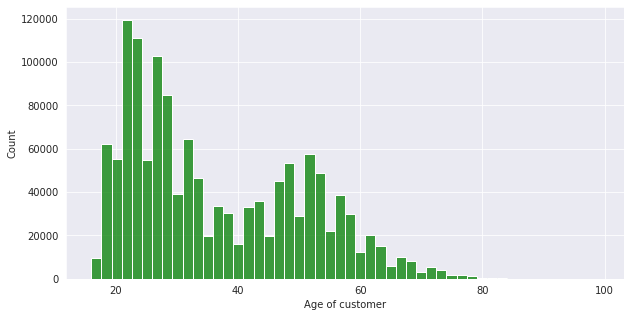

In [6]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='age', bins=50, color='green')
ax.set_xlabel('Age of customer')
plt.show()

### Customers' club status
Large majority are active members, with some beginning to active it. A very small part of customers left the club.

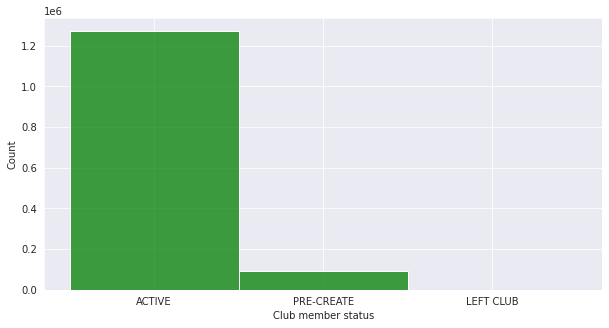

In [7]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='club_member_status', color='green')
ax.set_xlabel('Club member status')
plt.show()

### Fashion newsletter engagement
About 2/3 of customers do not receive fashion news

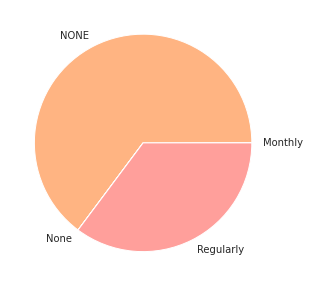

In [8]:
f, ax = plt.subplots(figsize=(10,5))
colors = sns.color_palette('pastel')
pie_data = customers_df[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

plt.pie(pie_data.customer_id, labels=pie_data.index, colors=colors)
plt.show()

## 2c. Transactions

`t_dat`: transaction date  
`customer_id`: unique customer id (customers_df)  
`article_id`: unique article id (articles_df)  
`price`: price of purchase  
`sales_channel_id`: 1 - online, 2 - in-store  

In [9]:
train_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


## 3. Recommendations

### Customer's Purchases within Last Week

In [10]:
# find each customer's most recent day of purchases
tmp = train_data.groupby('customer_id').t_dat.max().reset_index()
tmp.columns = ['customer_id','max_dat']
tmp['max_dat'] = pd.to_datetime(tmp['max_dat'])
tmp.head()

,customer_id,max_dat
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12


In [11]:
# merge tables to link customer_id, article_id, max purchase date, and today
train_data = train_data.merge(tmp,on=['customer_id'],how='left', suffixes=('', '_'))
train_data['t_dat'] = pd.to_datetime(train_data['t_dat'])

In [12]:
# find all purchases made within the past week of customer's last purchase
train_data['diff_dat'] = (train_data['max_dat'] - train_data['t_dat']).dt.days
train_data['diff_dat_chrono'] = pd.to_datetime(train_data['t_dat'].max()) - train_data['t_dat']
train_data = train_data.loc[train_data['diff_dat'] <= 6]

# find all purchases with date within the past week
recent_trans = train_data.loc[(train_data['diff_dat_chrono'].dt.days <= 6) & (train_data['sales_channel_id'] == 2)]
print('Train shape:',train_data.shape)
print('Recent trans shape:', recent_trans.shape)

Train shape: (5181535, 8)
Recent trans shape: (165809, 8)


In [13]:
# add all purchases into history
purchase_dict = {}

#for i,x in enumerate(zip(train_data['customer_id'], train_data['article_id'])):
for i,x in enumerate(zip(train_data['customer_id'], train_data['article_id'])):
    cust_id, art_id = x
    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}
    
    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    purchase_dict[cust_id][art_id] += 1
    
print(len(purchase_dict))

1362281


### Most Popular Items

Fill the remaining slots with the most popular items from this month

In [14]:
# merge tables to links transaction to the product type and its overall color
color_data = train_data
articles_df['prod_and_shade'] = articles_df['perceived_colour_value_name'] + ' ' + articles_df['product_type_name']
tmp = articles_df.loc[:, ['article_id', 'prod_and_shade']]
color_data = color_data.merge(tmp, on=['article_id'], how='left', suffixes=('', '_'))
recent_trans = recent_trans.merge(tmp, on=['article_id'], how='left', suffixes=('', '_'))

In [15]:
# create dictionary that shows frequency counts of product-color combos purchased by customer
"""
prod_and_shade = sorted(color_data.to_pandas().groupby(['customer_id']).prod_and_shade.value_counts().to_dict())
prod_shade_i = {}
prod_shade_list = []
for cust_id, prod in prod_and_shade:
    if cust_id not in prod_shade_i:
        prod_shade_list.append((cust_id, [prod]))
        prod_shade_i[cust_id] = len(prod_shade_i)
    else:
        prod_shade_list[prod_shade_i[cust_id]][1].append(prod)

prod_shade_dict = dict([item for item in prod_shade_list if len(item[1]) > 2])
"""

"\nprod_and_shade = sorted(color_data.to_pandas().groupby(['customer_id']).prod_and_shade.value_counts().to_dict())\nprod_shade_i = {}\nprod_shade_list = []\nfor cust_id, prod in prod_and_shade:\n    if cust_id not in prod_shade_i:\n        prod_shade_list.append((cust_id, [prod]))\n        prod_shade_i[cust_id] = len(prod_shade_i)\n    else:\n        prod_shade_list[prod_shade_i[cust_id]][1].append(prod)\n\nprod_shade_dict = dict([item for item in prod_shade_list if len(item[1]) > 2])\n"

In [16]:
train_data = train_data.loc[train_data['t_dat'] >= pd.to_datetime('2020-09-01')]
train_data = train_data.merge(tmp, on=['article_id'], how='left', suffixes=('', '_'))
print(train_data.shape)

(692104, 9)


In [17]:
# fill spots with top 3 items of customer's most frequent product-color category
"""
custom_freq1 = []
if cust_id in prod_shade_dict:
    custom_freq1 = recent_trans.loc[recent_trans['prod_and_shade'] ==  prod_shade_dict[cust_id][0]]
    if len(custom_freq1) >= 3:
        custom_freq1 = list(custom_freq1['article_id'].value_counts().nlargest(3).index)
    else:
        custom_freq1 = list(custom_freq1['article_id'].value_counts().index)
custom_freq1 = ['0' + str(item) for item in custom_freq1]
"""

trans_slice = train_data[['customer_id','article_id', 't_dat']]

def calc_pairs(train):
    # Calculate all articles purchased together
    dt = train.groupby(['customer_id','t_dat'])['article_id'].agg(list).rename('pair').reset_index()
    df = train[['customer_id', 't_dat', 'article_id']].merge(dt, on=['customer_id', 't_dat'], how='left')
    del dt
    
    df = df[['article_id', 'pair']].explode(column='pair') # Explode the rows vs list of articles
    df = df.loc[df['article_id'] != df['pair']].reset_index(drop=True) # Discard duplicates
    df = df.groupby(['article_id', 'pair']).size().rename('count').reset_index() # Count how many times each pair combination happens
    df = df.sort_values(['article_id' ,'count'], ascending=False).reset_index(drop=True) # Sort by frequency
    
    # Pick most frequent pair
    df['rank'] = df.groupby('article_id')['pair'].cumcount()
    df = df.loc[df['rank'] == 0].reset_index(drop=True)
    del df['rank']
    
    return df

# customers who bought an item also bought these two items
pairs = calc_pairs(trans_slice)
pairs_dict = dict(zip(pairs['article_id'], pairs['pair']))
pairs.head()

,article_id,pair,count
0,956217002,816832001,4
1,953763001,730683062,6
2,953450001,448509014,2
3,952938001,785018003,2
4,952267001,671607001,6


In [18]:
benchmark = submission[['customer_id']]
prediction_list = []
top12_str = list((train_data['article_id'].value_counts()).index)[:12]
top12 = ['0' + str(item) for item in top12_str]
base_pred = ' '.join(top12)

for i, cust_id in enumerate(submission['customer_id'].values.reshape((-1,))):
    if (i % 100000 == 0): print(i, end=' ')
    if cust_id in purchase_dict:
        # top 6 past purchases
        purch = ['0' + str(item[0]) for item in sorted((purchase_dict[cust_id]).items(), key=lambda x: x[1], reverse=True)]
        purch_slice = purch[:6] if len(purch) >= 6 else purch
        
        # items also bought for customer's top 3 purchases
        also_bought_slice = []
        for i in range(len(purch_slice)):
            if int(purch_slice[i][1:]) in pairs_dict:
                also_bought = pairs_dict[int(purch_slice[i][1:])]
                also_bought_slice.append('0' + str(also_bought))

        # fill remaining spots with popular items and remove repeats
        top12_slice = top12[:(12-len(purch_slice)-len(also_bought_slice))]
        top12_rev_slice = top12[(12-len(purch_slice)-len(also_bought_slice)):]
        for item in top12_slice:
            if item in purch_slice or item in also_bought_slice: 
                top12_slice.remove(item)
                top12_slice.append(top12_rev_slice.pop(0))

        s = ' '.join(purch_slice + also_bought_slice + top12_slice)
    else:
        s = base_pred
    prediction_list.append(s)

0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 

In [19]:
benchmark['prediction'] = prediction_list
benchmark.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0779781015 0751471001 0909370001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0889616001 0751471001 0909370001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0751471001 0909370001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0742079001 0732413001 0751471001 0909370001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0730683050 0927530004 0791587015 09...


## 4. Submission

In [20]:
benchmark.to_csv('submission.csv', index=False)

## Credits  
https://www.kaggle.com/code/vanguarde/h-m-eda-first-look  
https://www.kaggle.com/code/titericz/article-id-pairs-in-3s-using-cudf